In [4]:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

# Set folder paths for outputs

In [5]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'forest 26')

# Read the file

In [6]:
df = pd.read_csv(DATA / 'covtype.data.gz', compression='gzip', header=None, sep=',', quotechar='"', error_bad_lines=False)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# The raw data is one-hot encoded. We reverse encoded the data, to have categorical features back

### Prepare categorical column 'Wilderness_Area' from encoded column 10,11, 12 and 13

In [8]:
df['Wilderness_Area'] = 999

In [9]:
is_10_1 = df.iloc[:, 10] == 1
is_11_1 = df.iloc[:, 11] == 1
is_12_1 = df.iloc[:, 12] == 1
is_13_1 = df.iloc[:, 13] == 1

In [10]:
df.loc[is_10_1, 'Wilderness_Area'] = 0
df.loc[is_11_1, 'Wilderness_Area'] = 1
df.loc[is_12_1, 'Wilderness_Area'] = 2
df.loc[is_13_1, 'Wilderness_Area'] = 3

# Prepare categorical column 'Soil_Type' from encoded column 14 to 53

In [11]:
Soil_Type_df = df.iloc[:, 14:54]

In [12]:
def get_level(row):
    for c in Soil_Type_df.columns:
        if row[c]==1:
            return c - 14
        
df['Soil_Type'] = df.apply(get_level, axis=1)

In [13]:
Counter(df.Wilderness_Area)

Counter({0: 260796, 2: 253364, 3: 36968, 1: 29884})

In [14]:
columns_selected = [i for i in range(10)]

In [15]:
columns_selected.extend(('Wilderness_Area', 'Soil_Type', 54))

In [16]:
df = df[columns_selected]

In [17]:
df.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
             'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
              'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type', 'Cover_Type']

In [18]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,0,28,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,28,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,11,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,29,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,28,5


In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.shape

(581012, 13)

In [21]:
df.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area                       0
Soil_Type                             0
Cover_Type                            0
dtype: int64

In [22]:
Counter(df.Cover_Type)

Counter({5: 9493, 2: 283301, 1: 211840, 7: 20510, 3: 35754, 6: 17367, 4: 2747})

### There are 7 target labels of the dataset- 2 and 6 are randomly chosen among them(since this algorithm is built for binary classification)

In [23]:
df = df.loc[df['Cover_Type'].isin([2, 6])]
df['Cover_Type'].replace({2: 0, 6: 1},inplace = True)

In [24]:
len(df.Soil_Type.unique())

39

In [25]:
Counter(df.Cover_Type)

Counter({0: 283301, 1: 17367})

In [26]:
df_feature= df.drop('Cover_Type',1)
df_target= df[['Cover_Type']]
df_feature.index = pd.RangeIndex(len(df_feature.index))
df_target.index = pd.RangeIndex(len(df_target.index))

In [27]:
col_list = list(df_feature.columns)

In [28]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased
sc = StandardScaler()
df_feature = sc.fit_transform(df_feature)
df_feature = pd.DataFrame(df_feature, index=range(df_feature.shape[0]),
                          columns=col_list)

In [29]:
df_feature.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
0,-0.399128,-0.134249,-0.670227,-0.023920,0.336208,0.515973,0.822781,0.705092,-0.225044,2.841905,-0.99355,-1.291288
1,-0.485349,0.011818,0.568870,-0.148768,1.267114,0.460084,0.976798,0.705092,-0.577962,2.905575,-0.99355,0.724101
2,-1.420161,-0.198153,-1.083259,0.129739,-1.068933,-1.417154,0.668764,0.653128,-0.089306,2.778234,-0.99355,0.612135
3,-0.027019,-0.024699,-0.394872,0.470671,-0.348798,1.803275,0.822781,0.809022,-0.197896,1.377488,-0.99355,0.724101
4,-0.680480,-0.179895,1.119580,-0.590539,0.406465,0.537707,1.361841,-0.022415,-1.392390,2.820681,-0.99355,0.724101


# Create helper functions

In [30]:
## evaluate function generates the classification report of the loaded model based on the list of x and y values

def evaluate(x, y, threshold):
    x = np.array(x)
    y = np.ravel(y)
    pred = (loaded_model.predict_proba(x)[:,1] >= threshold).astype(bool)
    print(pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted']))
    print(classification_report(y, pred,digits=4))
    return None;

## Split the data to be 2-fold cross-validated
kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=False)
#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [11], 'max_features': [6],
'min_samples_leaf': [3], 'min_samples_split': [3], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

## generate_curves function creates ROC-AUC and PR-AUC curve of the loaded model and compare that wth the random classifier

def generate_curves(filename_old, filename_new, X_test, y_test):   

    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    loaded_model_old = pickle.load(open(filename_old, 'rb'))
    loaded_model_new = pickle.load(open(filename_new, 'rb'))

    test_prob_old = loaded_model_old.predict_proba(X_test)[:, 1]
    test_prob_new = loaded_model_new.predict_proba(X_test)[:, 1]
    
    fpr_old, tpr_old, _ = roc_curve(y_test,  test_prob_old)
    roc_auc_old = roc_auc_score(y_test,  test_prob_old)
    ax1.plot([0, 1], [0, 1], linestyle='--',label ='random, auc = %.4f'% 0.5, c = 'blue')
    ax1.plot(fpr_old, tpr_old ,label ='SMOTE-NC, auc = %.4f'% roc_auc_old, c= 'green')
    
    fpr_new, tpr_new, _ = roc_curve(y_test,  test_prob_new)
    roc_auc_new = roc_auc_score(y_test,  test_prob_new)
    ax1.plot(fpr_new, tpr_new ,label ='SMOTE-ENC, auc = %.4f'% roc_auc_new, c= 'red')
    
    ax1.legend(loc=4)

    ax1.set_title('ROC curve' ,fontsize=16)
    ax1.set_ylabel('True Positive Rate',fontsize=14)
    ax1.set_xlabel('False Positive Rate',fontsize=14)

    ax2 = f.add_subplot(122)
    

    precision_old, recall_old, _ = precision_recall_curve(y_test, test_prob_old)
    precision_new, recall_new, _ = precision_recall_curve(y_test, test_prob_new)
    
    auc_score_old = auc(recall_old, precision_old)
    auc_score_new = auc(recall_new, precision_new)
    
    random_auc = y_test.sum()/len(y_test)
    
    ax2.plot([0, 1], [random_auc, random_auc], linestyle='--', label ='random, auc = %.4f'% random_auc, c ='blue')
    ax2.plot(recall_old, precision_old, label = 'SMOTE-NC, auc=%.4f'% auc_score_old, c = 'green')
    ax2.plot(recall_new, precision_new, label = 'SMOTE-ENC, auc=%.4f'% auc_score_new, c = 'red')
    
    ax2.set_title('Precision Recall curve' ,fontsize=16)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_xlabel('Recall',fontsize=14)
    ax2.legend(loc='best')
    plt.show()
    f.savefig(REPORTS / 'forest26_roc_prc.jpeg', bbox_inches='tight')
    
    return None;


In [31]:
# Our New Proposed SMOTE Method
from scipy import stats
class MySMOTENC():
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        
    def chk_neighbors(self, nn_object, additional_neighbor):
        if isinstance(nn_object, Integral):
            return NearestNeighbors(n_neighbors=nn_object + additional_neighbor)
        elif isinstance(nn_object, KNeighborsMixin):
            return clone(nn_object)
        else:
            raise_isinstance_error(nn_name, [int, KNeighborsMixin], nn_object)     
    
    def generate_samples(self, X, nn_data, nn_num, rows, cols, steps, continuous_features_,):
        rng = check_random_state(42)

        diffs = nn_data[nn_num[rows, cols]] - X[rows]
        if sparse.issparse(X):
            sparse_func = type(X).__name__
            steps = getattr(sparse, sparse_func)(steps)
            X_new = X[rows] + steps.multiply(diffs)
        else:
            X_new = X[rows] + steps * diffs 

        X_new = (X_new.tolil() if sparse.issparse(X_new) else X_new)
        # convert to dense array since scipy.sparse doesn't handle 3D
        nn_data = (nn_data.toarray() if sparse.issparse(nn_data) else nn_data)

        all_neighbors = nn_data[nn_num[rows]]

        for idx in range(continuous_features_.size, X.shape[1]):
            mode = stats.mode(all_neighbors[:, :, idx], axis = 1)[0]

            X_new[:, idx] = np.ravel(mode)

        return X_new
    
    def make_samples(self, X, y_dtype, y_type, nn_data, nn_num, n_samples, continuous_features_, step_size=1.0):
        random_state = check_random_state(42)
        samples_indices = random_state.randint(low=0, high=len(nn_num.flatten()), size=n_samples)    
        steps = step_size * random_state.uniform(size=n_samples)[:, np.newaxis]
        rows = np.floor_divide(samples_indices, nn_num.shape[1])
        cols = np.mod(samples_indices, nn_num.shape[1])

        X_new = self.generate_samples(X, nn_data, nn_num, rows, cols, steps, continuous_features_)
        y_new = np.full(n_samples, fill_value=y_type, dtype=y_dtype)
        
        return X_new, y_new
    
    def cat_corr_pandas(self, X, target_df, target_column, target_value):
    # X has categorical columns
        categorical_columns = list(X.columns)
        X = pd.concat([X, target_df], axis=1)

        # filter X for target value
        is_target = X.loc[:, target_column] == target_value
        X_filtered = X.loc[is_target, :]

        X_filtered.drop(target_column, axis=1, inplace=True)

        # get columns in X
        nrows = len(X)
        encoded_dict_list = []
        nan_dict = dict({})
        c = 0
        imb_ratio = len(X_filtered)/len(X)
        OE_dict = {}
        
        for column in categorical_columns:
            for level in list(X.loc[:, column].unique()):
                
                # filter rows where level is present
                row_level_filter = X.loc[:, column] == level
                rows_in_level = len(X.loc[row_level_filter, :])
                
                # number of rows in level where target is 1
                O = len(X.loc[is_target & row_level_filter, :])
                E = rows_in_level * imb_ratio
                # Encoded value = chi, i.e. (observed - expected)/expected
                ENC = (O - E) / E
                OE_dict[level] = ENC
                
            encoded_dict_list.append(OE_dict)

            X.loc[:, column] = X[column].map(OE_dict)
            nan_idx_array = np.ravel(np.argwhere(np.isnan(X.loc[:, column])))
            if len(nan_idx_array) > 0 :
                nan_dict[c] = nan_idx_array
            c = c + 1
            X.loc[:, column].fillna(-1, inplace = True)
                
        X.drop(target_column, axis=1, inplace=True)
        return X, encoded_dict_list, nan_dict

    def fit_resample(self, X, y):
        X_cat_encoded, encoded_dict_list, nan_dict = self.cat_corr_pandas(X.iloc[:,np.asarray(self.categorical_features)], y, target_column='Cover_Type', target_value=1)

        X_cat_encoded = np.array(X_cat_encoded)
        y = np.ravel(y)
        X = np.array(X)

        unique, counts = np.unique(y, return_counts=True)
        target_stats = dict(zip(unique, counts))
        n_sample_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy = {key: n_sample_majority - value for (key, value) in target_stats.items() if key != class_majority}

        n_features_ = X.shape[1]
        categorical_features = np.asarray(self.categorical_features)
        if categorical_features.dtype.name == 'bool':
            categorical_features_ = np.flatnonzero(categorical_features)
        else:
            if any([cat not in np.arange(n_features_) for cat in categorical_features]):
                raise ValueError('Some of the categorical indices are out of range. Indices'
                            ' should be between 0 and {}'.format(n_features_))
            categorical_features_ = categorical_features

        continuous_features_ = np.setdiff1d(np.arange(n_features_),categorical_features_)

        target_stats = Counter(y)
        class_minority = min(target_stats, key=target_stats.get)

        X_continuous = X[:, continuous_features_]
        X_continuous = check_array(X_continuous, accept_sparse=['csr', 'csc'])
        X_minority = safe_indexing(X_continuous, np.flatnonzero(y == class_minority))

        if sparse.issparse(X):
            if X.format == 'csr':
                _, var = sparsefuncs_fast.csr_mean_variance_axis0(X_minority)
            else:
                _, var = sparsefuncs_fast.csc_mean_variance_axis0(X_minority)
        else:
            var = X_minority.var(axis=0)
        median_std_ = np.median(np.sqrt(var))

        X_categorical = X[:, categorical_features_]
        X_copy = np.hstack((X_continuous, X_categorical))
        
        X_cat_encoded = X_cat_encoded * median_std_
        X_encoded = np.hstack((X_continuous, X_cat_encoded))
        X_resampled = X_encoded.copy()
        y_resampled = y.copy()


        for class_sample, n_samples in sampling_strategy.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = safe_indexing(X_encoded, target_class_indices)
            nn_k_ = self.chk_neighbors(5, 1)
            nn_k_.fit(X_class)
            nns = nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]

            X_new, y_new = self.make_samples(X_class, y.dtype, class_sample, X_class, nns, n_samples, continuous_features_, 1.0)
            if sparse.issparse(X_new):
                X_resampled = sparse.vstack([X_resampled, X_new])
                sparse_func = 'tocsc' if X.format == 'csc' else 'tocsr'
                X_resampled = getattr(X_resampled, sparse_func)()
            else:
                X_resampled = np.vstack((X_resampled, X_new))
            y_resampled = np.hstack((y_resampled, y_new))

        X_resampled_copy = X_resampled.copy()
        i = 0
        for col in range(continuous_features_.size, X.shape[1]):
            encoded_dict = encoded_dict_list[i]
            i = i + 1
            for key, value in encoded_dict.items():
                X_resampled_copy[:, col] = np.where(np.round(X_resampled_copy[:, col], 4) == np.round(value * median_std_, 4), key, X_resampled_copy[:, col])

        for key, value in nan_dict.items():
            for item in value:
                X_resampled_copy[item, continuous_features_.size + key] = X_copy[item, continuous_features_.size + key]

               
        X_resampled = X_resampled_copy   
        indices_reordered = np.argsort(np.hstack((continuous_features_, categorical_features_)))
        if sparse.issparse(X_resampled):
            col_indices = X_resampled.indices.copy()
            for idx, col_idx in enumerate(indices_reordered):
                mask = X_resampled.indices == col_idx
                col_indices[mask] = idx
            X_resampled.indices = col_indices
        else:
            X_resampled = X_resampled[:, indices_reordered]
        return X_resampled, y_resampled

In [32]:
## Apply the random-forest classifier along with the NEW SMOTE-ENC method

filename = (MODELS / 'forest_mysmotenc_26.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [10, 11]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(df_feature, df_target)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 27.8min finished


In [ ]:
## Apply the random-forest classifier along with the exsting SMOTE-NC method

filename = (MODELS / 'forest_smotenc_26.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [10, 11]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(df_feature, df_target)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 25.1min finished


In [39]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'forest_mysmotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')
evaluate(df_feature, df_target, threshold)
# evaluate(df_test_feature, df_test_target, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted   False  True 
Actual                  
0          277448   5853
1              27  17340
              precision    recall  f1-score   support

           0     0.9999    0.9793    0.9895    283301
           1     0.7476    0.9984    0.8550     17367

    accuracy                         0.9804    300668
   macro avg     0.8738    0.9889    0.9223    300668
weighted avg     0.9853    0.9804    0.9817    300668



array([0.50877495, 0.01784696, 0.00535509, 0.01339436, 0.01020889,
       0.04087845, 0.00889633, 0.00895134, 0.00565646, 0.02952876,
       0.13863105, 0.21187735])

In [40]:
## Evaluate SMOTE-NC performance on train and test set
filename = (MODELS / 'forest_smotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')
evaluate(df_feature, df_target, threshold)
# evaluate(df_test_feature, df_test_target, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted   False  True 
Actual                  
0          277450   5851
1              31  17336
              precision    recall  f1-score   support

           0     0.9999    0.9793    0.9895    283301
           1     0.7477    0.9982    0.8550     17367

    accuracy                         0.9804    300668
   macro avg     0.8738    0.9888    0.9222    300668
weighted avg     0.9853    0.9804    0.9817    300668



array([0.5145266 , 0.01565978, 0.00542271, 0.01184415, 0.00970854,
       0.04172761, 0.01071607, 0.00946749, 0.00569536, 0.03000965,
       0.14163028, 0.20359176])

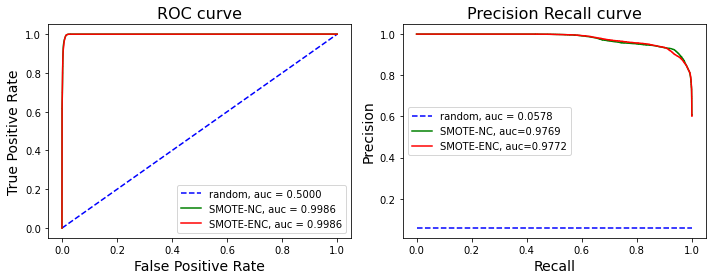

In [41]:
##Create ROC-AUC and PR-AUC curve
generate_curves(MODELS / 'forest_smotenc_26.sav', MODELS / 'forest_mysmotenc_26.sav', df_feature, df_target)

In [ ]:
## Find out top 4 most important features using our new SMOTE-ENC method
filename = (MODELS / 'forest_mysmotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(4))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest26_newsmote.jpeg', bbox_inches='tight')

In [ ]:
## Find out top 4 most important features using existing SMOTE-NC method
filename = (MODELS / 'forest_smotenc_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(4))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest26_oldsmote.jpeg', bbox_inches='tight')